Mixed effects model

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  score     
No. Observations:    2500     Method:              REML      
No. Groups:          50       Scale:               0.4981    
Min. group size:     50       Log-Likelihood:      -2716.1479
Max. group size:     50       Converged:           Yes       
Mean group size:     50.0                                    
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept         -0.336    0.028 -11.778 0.000 -0.391 -0.280
school_treatment  -0.346    0.019 -17.813 0.000 -0.385 -0.308
student_treatment  0.528    0.010  52.122 0.000  0.508  0.548
Group Var          0.025    0.011                            



/tmp/ipykernel_18440/2286522155.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  school_effects = [fixed_effects['school_treatment'] + re[0] for re in random_effects.values()]


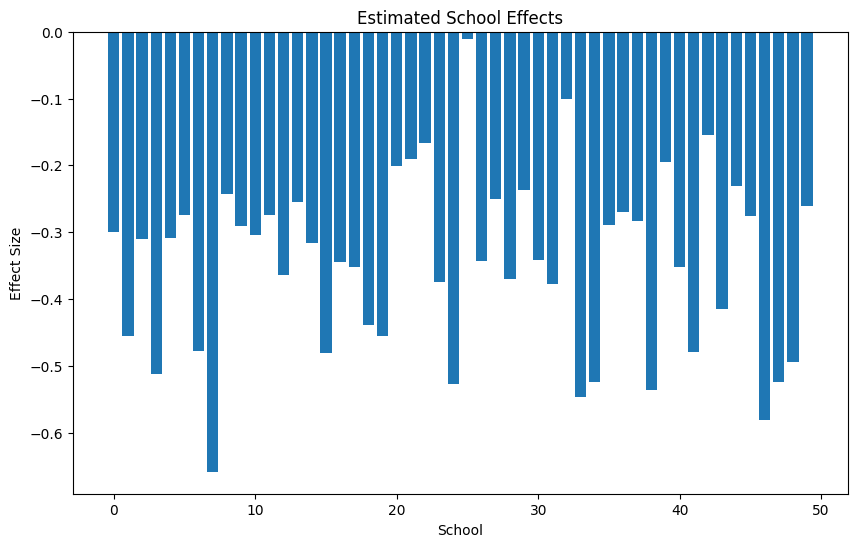

Mean squared error: 0.52
R-squared score: 0.72


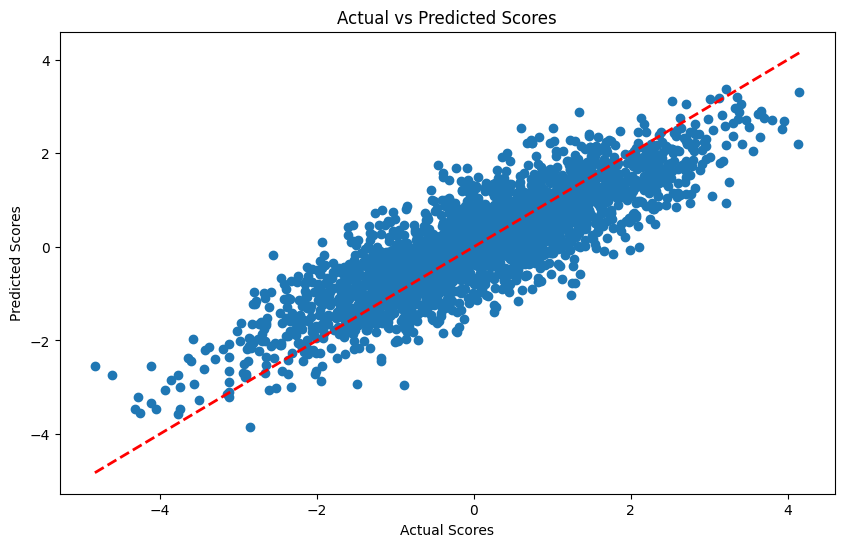

In [19]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

n_schools = 50
n_students_per_school = 50

true_mu = 0
true_tau = 1
true_sigma = 1
true_theta = 0.5
true_school_treatment = 0.5
true_student_treatment = 0.5
true_school_notation = 0.5


school_effects = np.random.normal(0, true_tau,size=(n_schools,1)) # we sample 'a' values

student_scores =true_mu+school_effects@(1+np.zeros((1,n_students_per_school))) +np.random.normal( 0, 1,(n_schools,n_students_per_school)) # we sample 'b' values

school_treatment =true_school_treatment+ np.random.normal(0, 1, size=(n_schools,1))+np.reshape(np.mean(student_scores,axis=1),(n_schools,1))+school_effects # we get c values

student_treatment =np.random.normal(0,1,size=(n_schools,n_students_per_school)) + student_scores+true_student_treatment+school_treatment@(1+np.zeros((1,n_students_per_school))) # we get d values

# Calculate school notation (e) for each school
school_notation = np.random.normal(true_school_notation, 1, n_schools)+np.mean(student_treatment,axis=1) # we get e values


# Create a DataFrame
data = pd.DataFrame({
    'school': np.repeat(range(n_schools), n_students_per_school),
    'score': student_scores.flatten(),
    'school_effects': np.repeat(school_effects, n_students_per_school),
    'school_treatment': np.repeat(school_treatment, n_students_per_school),
    'student_treatment': student_treatment.flatten(),
    'school_notation': np.repeat(school_notation, n_students_per_school)
})


# Import necessary libraries for mixed effects model
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm

# Prepare the data for mixed effects model
data['school'] = data['school'].astype('category')

# Define the mixed effects model
mixed_model = mixedlm("score ~ school_treatment + student_treatment", 
                      data=data, 
                      groups=data["school"])

# Fit the model
mixed_model_fit = mixed_model.fit()

# Print the summary of the model
print(mixed_model_fit.summary())

# Extract fixed effects
fixed_effects = mixed_model_fit.fe_params

# Extract random effects (school effects)
random_effects = mixed_model_fit.random_effects

# Combine fixed and random effects for each school
school_effects = [fixed_effects['school_treatment'] + re[0] for re in random_effects.values()]

# Plot school effects
plt.figure(figsize=(10, 6))
plt.bar(range(n_schools), school_effects)
plt.title('Estimated School Effects')
plt.xlabel('School')
plt.ylabel('Effect Size')
plt.show()

# Make predictions
y_pred = mixed_model_fit.predict(data)

# Calculate and print model performance metrics
mse = mean_squared_error(data['score'], y_pred)
r2 = r2_score(data['score'], y_pred)

print(f"Mean squared error: {mse:.2f}")
print(f"R-squared score: {r2:.2f}")

# Plot actual vs predicted scores
plt.figure(figsize=(10, 6))
plt.scatter(data['score'], y_pred)
plt.plot([data['score'].min(), data['score'].max()], [data['score'].min(), data['score'].max()], 'r--', lw=2)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores')
plt.show()

Summary statistics of generated data:
count    2500.000000
mean       -0.006399
std         0.765445
min        -2.085813
25%        -0.581648
50%         0.049166
75%         0.567361
max         2.129144
Name: predicted_score, dtype: float64


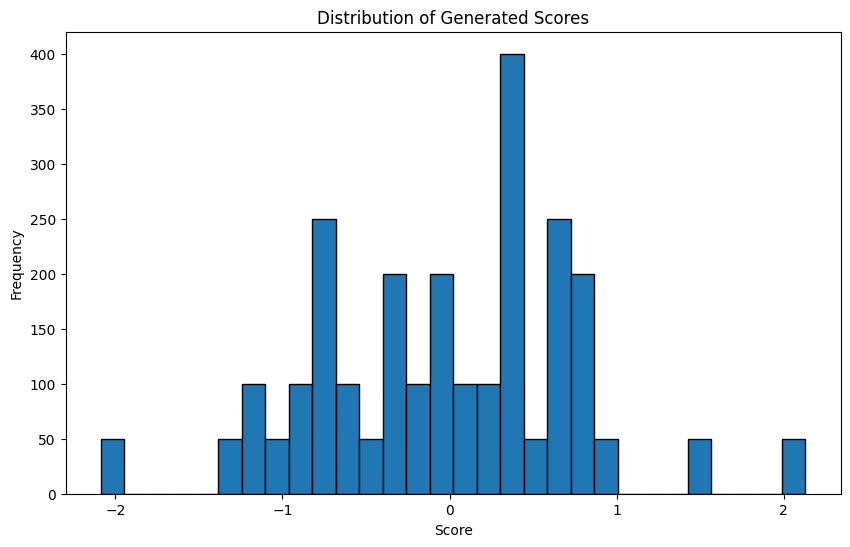

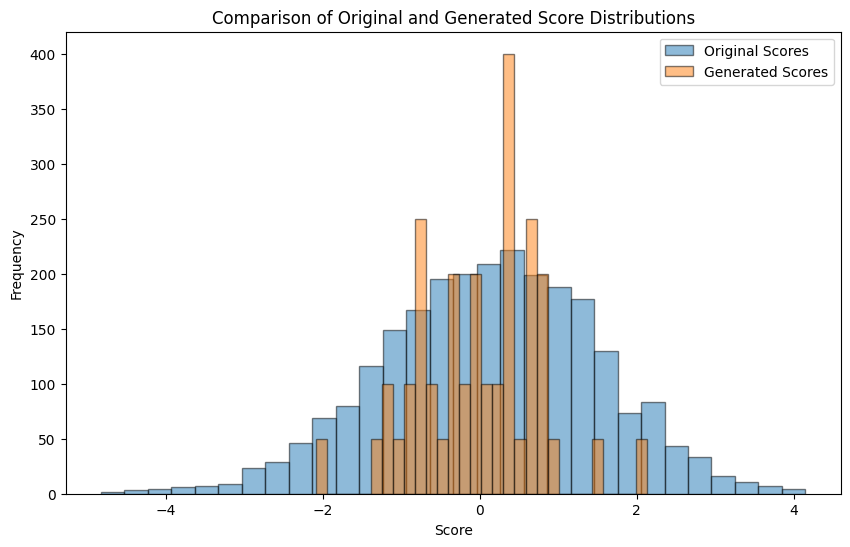

In [20]:
# Generate new data based on the fitted Random Forest model

# Create a new dataset with the same structure as the original
new_data = pd.DataFrame(columns=X.columns)

# Generate random values for each school
for school in range(n_schools):
    school_data = pd.DataFrame(0, index=range(n_students_per_school), columns=X.columns)
    school_data[f'school_{school}'] = 1
    new_data = pd.concat([new_data, school_data], ignore_index=True)

# Use the trained model to predict scores for the new data
new_scores = rf_model.predict(new_data)

# Add the predicted scores to the new dataset
new_data['predicted_score'] = new_scores

# Display summary statistics of the generated data
print("Summary statistics of generated data:")
print(new_data['predicted_score'].describe())

# Plot the distribution of generated scores
plt.figure(figsize=(10, 6))
plt.hist(new_data['predicted_score'], bins=30, edgecolor='black')
plt.title('Distribution of Generated Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Compare the distribution of original and generated scores
plt.figure(figsize=(10, 6))
plt.hist(data['score'], bins=30, alpha=0.5, label='Original Scores', edgecolor='black')
plt.hist(new_data['predicted_score'], bins=30, alpha=0.5, label='Generated Scores', edgecolor='black')
plt.title('Comparison of Original and Generated Score Distributions')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np



In [23]:
# Train a classifier to distinguish between original and generated data

# Combine original and generated data
original_data = data.copy()
original_data['is_original'] = 1
generated_data = new_data.copy()
generated_data['is_original'] = 0

combined_data = pd.concat([original_data, generated_data], ignore_index=True)

# Prepare features and target
X_combined = combined_data.drop(['score', 'predicted_score', 'is_original'], axis=1)
y_combined = combined_data['is_original']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Create a pipeline with SimpleImputer and KNeighborsClassifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', KNeighborsClassifier())
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Generated', 'Original']))

# Note: KNeighborsClassifier doesn't have feature_importances_ attribute
# So we'll skip the feature importance plot

print("Note: Feature importance plot is not available for KNeighborsClassifier.")


Classifier accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

   Generated       1.00      1.00      1.00       500
    Original       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Note: Feature importance plot is not available for KNeighborsClassifier.


In [24]:
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline that first imputes missing values, then applies KNN
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # You can change 'mean' to 'median' or 'most_frequent' if needed
    ('classifier', KNeighborsClassifier())
])

# Define the parameter grid to search
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2]  # Only relevant for Minkowski metric
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available cores
)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score:.4f}")

# Use the best model for predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy with best model: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Generated', 'Original']))

Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Best cross-validation score: 1.0000
Test accuracy with best model: 1.0000

Classification Report:
              precision    recall  f1-score   support

   Generated       1.00      1.00      1.00       500
    Original       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



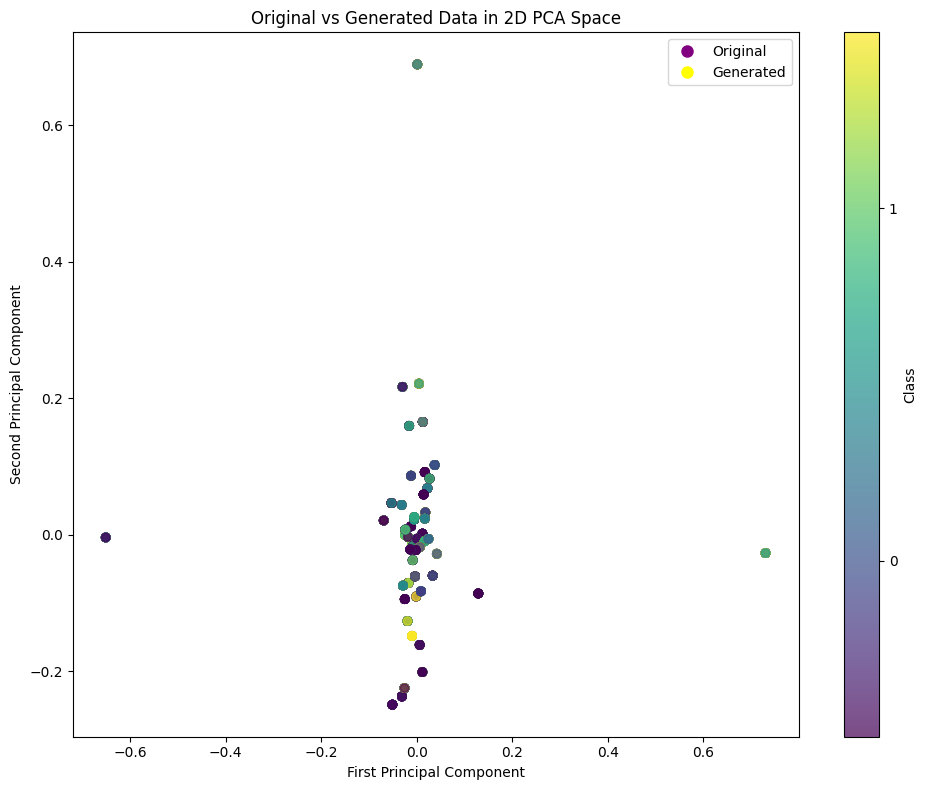

In [25]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)

# Add labels and title
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Original vs Generated Data in 2D PCA Space')

# Add a color bar
plt.colorbar(scatter, label='Class', ticks=[0, 1])
plt.clim(-0.5, 1.5)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Original', 
                              markerfacecolor='purple', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Generated', 
                              markerfacecolor='yellow', markersize=10)]
plt.legend(handles=legend_elements, loc='best')

# Show the plot
plt.tight_layout()
plt.show()
